In [1]:
''' 
Tutorial from:
https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c

'''

import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finta import TA  #FinTA (Financial Technical Analysis)

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [2]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
# Constants explained here   https://github.com/peerchemist/finta
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [3]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  Adj Close  volume
Date                                                                     
1995-11-20  60.281250  60.296875  59.859375  59.875000  36.634121  448800
1995-11-21  59.937500  60.359375  59.921875  60.359375  36.930470  119200
1995-11-22  60.312500  60.375000  60.171875  60.171875  36.815739  351600
1995-11-24  60.234375  60.328125  60.187500  60.328125  36.911354   62400
1995-11-27  60.453125  60.640625  60.343750  60.343750  36.920910  273000


<Axes: xlabel='Date'>

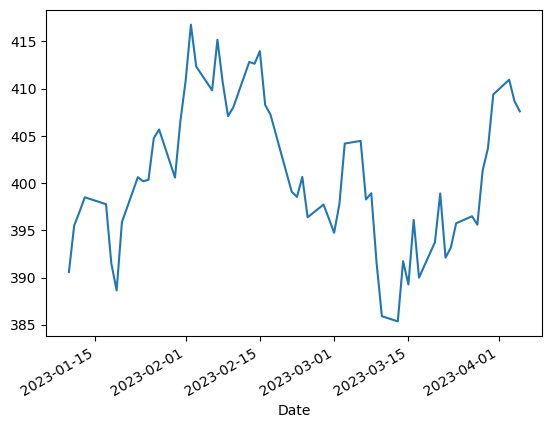

In [4]:
tmp = data.iloc[-60:]
tmp['close'].plot()

In [5]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()


<Axes: xlabel='Date'>

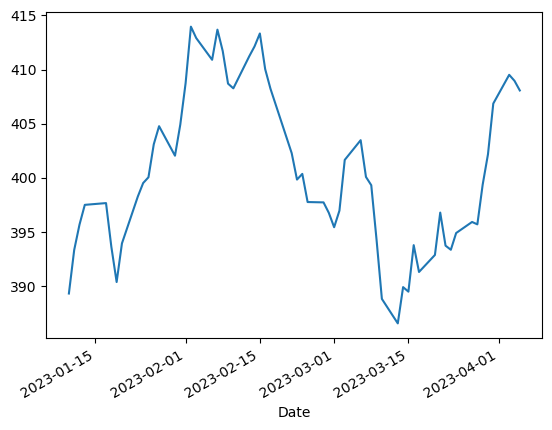

In [6]:
data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [7]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data



In [8]:
data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [9]:
data.tail(10)

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2023-03-23,393.374072,45.328343,-2.281752,-2.429663,45.814752,4.111039e+10,6.949261,-0.906087,34.377455,-1.680275,3.577287e+10,-6.655015,-0.024942,1.021184,0.935559,0.993218,0.990681,0.991891,0.998756,0.958695
2023-03-24,394.918425,47.807310,-2.041688,-2.352068,54.157645,4.115016e+10,7.171473,6.078867,29.181084,-1.105212,3.588313e+10,-17.170542,-0.048424,1.079463,0.880673,0.997174,0.994816,0.996065,1.002230,0.931432
2023-03-27,395.939943,49.440348,-1.748847,-2.231424,69.709416,4.114903e+10,7.078391,9.362107,34.414154,0.420965,3.596983e+10,21.288023,-0.032298,1.062970,0.941185,0.999758,0.997508,0.998731,1.004016,0.766585
2023-03-28,395.718984,49.082611,-1.517110,-2.088561,68.727982,4.116219e+10,7.030955,5.792234,34.664540,1.769220,3.589862e+10,14.856770,-0.025362,1.040508,0.957183,0.999216,0.997089,0.998296,1.002878,0.671073
2023-03-29,399.379148,54.903626,-1.026282,-1.876105,92.120185,4.120567e+10,6.727609,9.872787,39.689563,3.311445,3.597392e+10,73.922351,-0.002608,0.998118,1.024712,1.008291,1.006023,1.007024,1.010108,0.745679
2023-03-30,402.187710,58.796208,-0.405990,-1.582082,96.711970,4.124365e+10,6.350295,8.388993,46.294130,3.144427,3.604567e+10,115.927947,0.027335,0.898369,1.116860,1.015075,1.012495,1.013153,1.014302,0.746565
2023-03-31,406.869208,64.324069,0.458073,-1.174051,98.124019,4.132205e+10,6.044592,15.546163,54.384146,4.457654,3.614356e+10,171.440729,0.056027,0.790766,1.199204,1.026350,1.023151,1.023244,1.021662,1.015465
2023-04-03,409.521731,67.023564,1.341423,-0.670956,98.343481,4.138076e+10,5.756652,16.627671,52.240053,3.992652,3.622163e+10,203.563675,0.059901,0.756078,1.220459,1.032372,1.028427,1.027865,1.023492,0.836302
2023-04-04,408.968114,65.902720,1.974057,-0.141954,91.171404,4.137603e+10,5.604803,12.163691,60.850746,4.509080,3.615101e+10,184.090111,0.068545,0.703403,1.248219,1.030350,1.025776,1.024667,1.018356,0.788464


In [10]:
# This line captures 5 rows corresponding to the 5 days of the week on July 27th.
live_pred_data = data.iloc[-16:-11]
#live_pred_data

In [21]:
#    prediction = (data.shift(-window)['close'] >= data['close'])
#    prediction = prediction.iloc[:-window]
#    data['pred'] = prediction.astype(int)
window = 15
prediction = data.shift(-window)['close'] >= data['close']
prediction = prediction.iloc[:-window]

data['pred'] = prediction.astype(int)
data.head(20)

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,,
1995-11-20,59.875000,NaN,0.000000,0.000000,NaN,-4.167429e+05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1995-11-21,60.233796,100.000000,0.008050,0.004472,NaN,-3.144169e+05,NaN,NaN,NaN,NaN,...,66.666667,NaN,NaN,NaN,1.002958,1.002918,1.002884,1.002715,0.648395,1.0
1995-11-22,60.191744,88.792752,0.008953,0.006309,NaN,-3.885265e+05,NaN,NaN,NaN,NaN,...,72.623933,NaN,NaN,NaN,1.001489,1.001443,1.001404,1.001217,0.978284,1.0
1995-11-24,60.281742,91.093370,0.012394,0.008370,NaN,-3.346741e+05,NaN,NaN,NaN,NaN,...,86.194918,NaN,NaN,NaN,1.002216,1.002151,1.002098,1.001839,0.561773,1.0
1995-11-27,60.322260,91.899585,0.015615,0.010525,NaN,-4.845429e+05,NaN,NaN,NaN,NaN,...,122.090275,NaN,NaN,NaN,1.002287,1.002205,1.002137,1.001811,0.915958,1.0
1995-11-28,60.753427,96.024030,0.035695,0.017348,NaN,-1.859339e+05,NaN,NaN,NaN,NaN,...,149.494616,NaN,NaN,NaN,1.007784,1.007606,1.007457,1.006708,1.373561,1.0
1995-11-29,60.944291,96.800612,0.056604,0.027282,NaN,1.619532e+05,NaN,NaN,NaN,NaN,...,152.401755,NaN,NaN,NaN,1.009276,1.008994,1.008757,1.007572,1.481870,0.0
1995-11-30,60.919559,94.232172,0.068537,0.037197,NaN,1.051990e+05,NaN,NaN,NaN,NaN,...,123.378444,NaN,NaN,NaN,1.007671,1.007320,1.007026,1.005598,1.058884,1.0
1995-12-01,60.961693,94.499911,0.077849,0.046587,NaN,1.206373e+05,NaN,NaN,NaN,NaN,...,101.079560,NaN,NaN,NaN,1.007355,1.006944,1.006603,1.004986,1.197622,1.0


In [22]:
'''
Now comes one of the most important part of this project — computing the truth values. 
Without these, we wouldn’t even be able to train a machine learning model to make predictions.

How do we obtain truth value? Well it’s quite intuitive. If we want to know when a stock will increase or decrease 
(to make a million dollars hopefully!) we would just need to look into the future and observe the price 
to determine if we should buy or sell right now. Well, with all this historical data, that’s exactly what we can do.

Going back to the table where we initially pulled our data, if we want to know the buy (1)
or sell (0) decision on the day of 1993–03–29 (where the closing price was 11.4375), 
we just need to look X days ahead to see if the price is higher or lower than that on 1993–03–29.
So if we look 1 day ahead, we see that the price increased to 11.5. 
So the truth value on 1993–03–29 would be a buy (1).

Since this is also the last step of data processing, we remove all of the NaN value 
that our indicators and prediction generated, as well as removing the ‘close’ column.

'''
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail(10)

# Because we used Pandas’ shift() function, we lose about 15 rows from the end of the dataset 
# (which is why I captured the week of July 27th before this step).

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2023-03-02,41.082991,-1.068837,0.964741,18.802780,4.107629e+10,4.940124,-16.353486,33.721110,-3.465154,3.622238e+10,-110.310197,-0.051679,1.177008,0.739224,1.000697,0.991920,0.988380,0.991318,1.007479,0.0
2023-03-03,49.788747,-0.920132,0.587767,41.084499,4.114445e+10,4.974861,-8.382218,40.789916,-2.542770,3.631223e+10,-56.622509,-0.022146,1.060961,0.815760,1.012254,1.003455,1.000037,1.002509,1.009652,0.0
2023-03-06,52.714747,-0.647872,0.340639,49.749061,4.114048e+10,4.927126,-4.747282,41.267425,-2.382912,3.639099e+10,-15.746773,-0.015302,1.035396,0.856870,1.016507,1.007638,1.004264,1.005871,0.902415,0.0
2023-03-07,47.196643,-0.697818,0.132947,33.606680,4.107836e+10,4.933635,-2.194553,33.954622,-2.427464,3.629302e+10,-36.959413,-0.029146,1.071942,0.809471,1.007803,0.999204,0.996098,0.997844,1.100023,0.0
2023-03-08,46.026806,-0.790016,-0.051645,31.063054,4.107165e+10,4.867663,-0.521091,27.923093,-2.181293,3.621014e+10,-55.251880,-0.040461,1.123765,0.770931,1.005760,0.997416,0.994579,0.996611,0.941439,1.0
2023-03-09,39.128783,-1.256235,-0.292563,8.041706,4.100159e+10,5.129380,-6.097386,27.365476,-1.991391,3.610837e+10,-89.319447,-0.051053,1.108322,0.728276,0.993172,0.985479,0.983177,0.986634,1.126782,1.0
2023-03-10,33.334505,-2.041198,-0.642290,8.022669,4.089747e+10,5.435017,-8.939586,25.939426,-2.754368,3.594984e+10,-147.425637,-0.061628,1.130737,0.714073,0.979862,0.973125,0.971578,0.977415,1.559044,1.0
2023-03-13,31.261995,-2.813358,-1.076504,15.826294,4.086014e+10,5.602347,-11.169372,24.656811,-3.446674,3.579178e+10,-173.544866,-0.062225,1.157396,0.751221,0.974657,0.968897,0.968126,0.976330,1.422826,1.0
2023-03-14,37.462052,-3.119116,-1.485026,30.603409,4.088367e+10,5.822080,-6.853779,33.695907,-1.974059,3.594444e+10,-135.203656,-0.045385,1.103764,0.826217,0.983426,0.978301,0.978045,0.987291,1.293573,1.0


In [9]:
'''
Right before we train our model we must split up the data into a train set and test set. However, due to the nature of time-series’, we need to handle this part carefully. If we randomize our train-test set, we could encounter a look-ahead bias which is not good for predicting the stock market. It’s caused when you train your model on data it would’ve already seen.

To prevent this we are going to be training the model using a different technique called cross-validation. The image below illustrates how we are going to partition our data and test the accuracy of the model.
'''
'''
First, we’re going to use multiple classifiers to create an ensemble model. The goal here is to combine the predictions of several models to try and improve on predictability. For each sub-model, we’re also going to use a feature from Sklearn, GridSearchCV, to optimize each model for the best possible results.

First we create the random forest model.
'''
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    
# rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

In [10]:
# Then the KNN model.

def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
    
    
# knn_model = _train_KNN(X_train, y_train, X_test, y_test)

In [11]:
# And now finally we create the voting classifier

# gbt_model, -???  , ('gbt', gbt_model) -???

def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
# ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

In [ ]:
'''
Once we set up our models, we can put it together with the cross-validation. 
We start by writing some code that will allow us to iterate over our data with many evenly sized chunks.
'''

def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        '''
        Now we add in the code that will split the partitions into train and test sets. 
        It’s very important to set shuffle=False in the train_test_split function —it’s how you avoid the look-ahead bias.
        '''

        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        #Finally we incorporate our models.
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
'''        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
'''
            
cross_Validation(data)

10 50
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]


/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 18}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
20 60
{'n_estimators': 110}
              precision  

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       0.17      1.00      0.29         2

    accuracy                           0.17        12
   macro avg       0.08      0.50      0.14        12
weighted avg       0.03      0.17      0.05        12

[[ 0 10]
 [ 0  2]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
30 70
{'n_estimators': 140}
          

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88         7
         1.0       1.00      0.60      0.75         5

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.81        12
weighted avg       0.87      0.83      0.82        12

[[7 0]
 [2 3]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88         7
         1.0       1.00      0.60      0.75         5

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.81        12
weighted avg       0.87      0.83      0.82        12

[[7 0]
 [2 3]]
rf prediction is  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
40 80
{'n_estimators': 110}
              preci

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.38      0.50      0.43         6
         1.0       0.25      0.17      0.20         6

    accuracy                           0.33        12
   macro avg       0.31      0.33      0.31        12
weighted avg       0.31      0.33      0.31        12

[[3 3]
 [5 1]]
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.38      0.50      0.43         6
         1.0       0.25      0.17      0.20         6

    accuracy                           0.33        12
   macro avg       0.31      0.33      0.31        12
weighted avg       0.31      0.33      0.31        12

[[3 3]
 [5 1]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
50 90
{'n_estimators': 150}
              preci

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
60 100
{'n_estimators': 110}
          

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.50      0.75      0.60         4
         1.0       0.83      0.62      0.71         8

    accuracy                           0.67        12
   macro avg       0.67      0.69      0.66        12
weighted avg       0.72      0.67      0.68        12

[[3 1]
 [3 5]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.50      0.75      0.60         4
         1.0       0.83      0.62      0.71         8

    accuracy                           0.67        12
   macro avg       0.67      0.69      0.66        12
weighted avg       0.72      0.67      0.68        12

[[3 1]
 [3 5]]
rf prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
truth values are  [0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
70 110
{'n_estimators': 110}
              prec

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
knn prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
80 120
{'n_estimators': 130}
             

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
90 130
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.25


/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
100 140
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        10
         1.0       0.40      1.00      0.57         2

    accuracy                           0.75        12
   macro avg       0.70      0.85      0.70        12
weighted avg       0.90      0.75      0.78        12

[[7 3]
 [0 2]]


/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        10
         1.0       0.50      1.00      0.67         2

    accuracy                           0.83        12
   macro avg       0.75      0.90      0.78        12
weighted avg       0.92      0.83      0.85        12

[[8 2]
 [0 2]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        10
         1.0       0.50      1.00      0.67         2

    accuracy                           0.83        12
   macro avg       0.75      0.90      0.78        12
weighted avg       0.92      0.83      0.85        12

[[8 2]
 [0 2]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
110 150
{'n_estimators': 130}
              pre

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.1

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
120 160
{'n_estimators': 110}
              precision 

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
130 170
{'n_estimators': 110}
         

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.1

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
140 180
{'n_estimators': 110}
              precision 

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         3
         1.0       1.00      0.67      0.80         9

    accuracy                           0.75        12
   macro avg       0.75      0.83      0.73        12
weighted avg       0.88      0.75      0.77        12

[[3 0]
 [3 6]]
0.5
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         3
         1.0       1.00      0.33      0.50         9

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 0]
 [6 3]]
rf prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
150 190
{'n_estimators': 110}
              precision    recal

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.67      0.40      0.50         5

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12

[[6 1]
 [3 2]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
rf prediction is  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
160 200
{'n_estimators': 110}
              pre

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
ensemble prediction is  [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
170 210
{'n_estimators': 110}
              precision    recal

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
180 220
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
190 230
{'n_estimators': 110}
         

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
200 240
{'n_estimators': 110}
         

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python

{'n_neighbors': 3}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
210 250
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00   

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python

{'n_neighbors': 3}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
220 260
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40    

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
230 270
{'n_estimators': 140}
              precision    reca

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         3
         1.0       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

[[3 0]
 [2 7]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         3
         1.0       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

[[3 0]
 [2 7]]
rf prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
240 280
{'n_estimators': 150}
              pre

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 16}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
250 290
{'n_estimators': 110}
        

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80        12

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[0 0]
 [4 8]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
260 300
{'n_estimators': 110}
              pre

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python

{'n_neighbors': 5}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
270 310
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96    

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
280 320
{'n_estimators': 110}
         

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
290 330
{'n_estimators': 110}
        

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.1

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
ensemble prediction is  [1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
300 340
{'n_estimators': 160}
              pre

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78        11
         1.0       0.20      1.00      0.33         1

    accuracy                           0.67        12
   macro avg       0.60      0.82      0.56        12
weighted avg       0.93      0.67      0.74        12

[[7 4]
 [0 1]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12

[[10  1]
 [ 0  1]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
310 350
{'n_estimators': 110}
             

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.00        11

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 1  0]
 [11  0]]
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.08      1.00      0.15         1
         1.0       0.00      0.00      0.00        11

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 1  0]
 [11  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
320 360
{'n_estimators': 110}
        

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.17      0.29        12

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 0  0]
 [10  2]]
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.17      0.29        12

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 0  0]
 [10  2]]
rf prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
330 370
{'n_estimators': 110}
        

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/serguz/anaconda3/lib/python3.10/site-packages/

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
340 380
{'n_estimators': 110}
              precision 

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
350 390
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00   

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
360 400
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00   

/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/serguz/anaconda3/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
370 410


In [52]:
def testing_Models(data):
        # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set

    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        '''
        Now we add in the code that will split the partitions into train and test sets. 
        It’s very important to set shuffle=False in the train_test_split function —it’s how you avoid the look-ahead bias.
        '''

        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
    print(X_train)

    
testing_Models(data)

            14 period RSI      MACD    SIGNAL  14 period STOCH %K  \
Date                                                                
2023-01-13      63.180055  0.638425 -1.219618           96.136818   
2023-01-17      63.357511  1.260491 -0.723596           91.537901   
2023-01-18      56.155138  1.412419 -0.296393           72.281582   
2023-01-19      51.087629  1.255199  0.013925           56.449189   
2023-01-20      55.784308  1.402070  0.291554           72.738984   
2023-01-23      60.723766  1.846981  0.602639           91.785670   
2023-01-24      62.028125  2.273251  0.936762           94.265749   
2023-01-25      62.601615  2.623654  1.274140           96.696799   
2023-01-26      65.794418  3.111253  1.641563           98.580809   
2023-01-27      67.436480  3.591079  2.031466           92.050182   
2023-01-30      62.193788  3.708802  2.366933           78.560312   
2023-01-31      65.263617  3.988128  2.691172           91.143879   
2023-02-01      68.874419  4.46579